In [1]:
from exp.nb_Tesis import *


In [2]:
# pip install --upgrade efficientnet-pytorch


In [3]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [4]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [5]:
# !unzip ISIC_2019_Training_Input.zip

In [6]:
min_dim = 512# 448

trainImagesFolderName = 'ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [7]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [9]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [10]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [11]:
!nvidia-smi

Mon Mar  9 03:12:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   31C    P8    16W / 250W |   1793MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [13]:
# torch.cuda.set_device(0)

## Load the dataset

In [15]:
destFolder = 'small_512_ISIC_2019_Training_Input'

In [32]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms,size=428)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

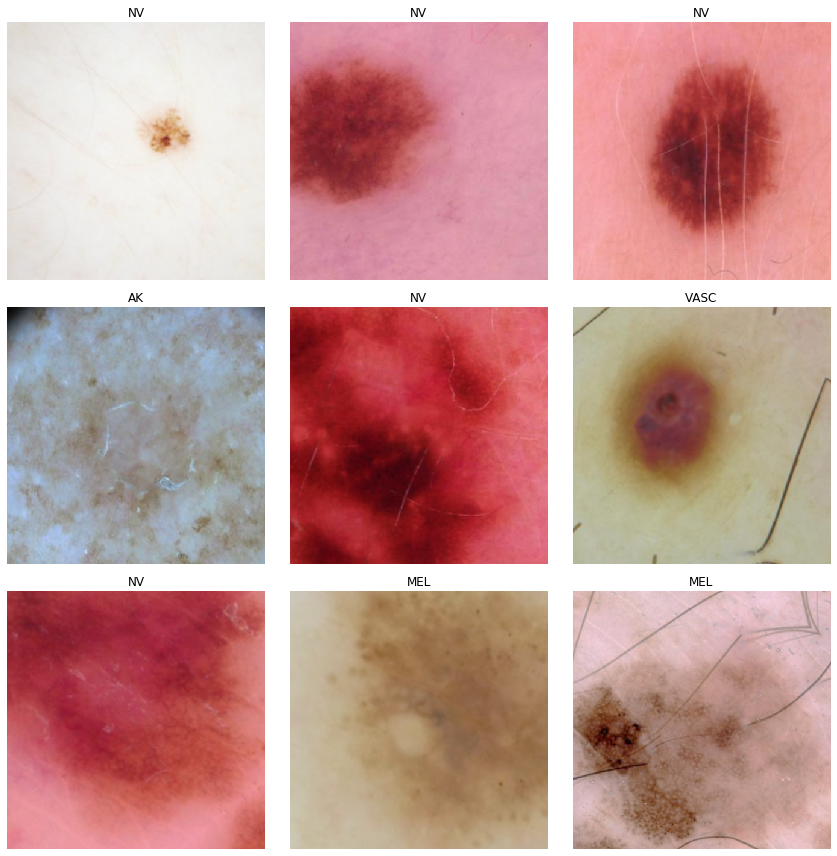

In [33]:
data.show_batch(3)

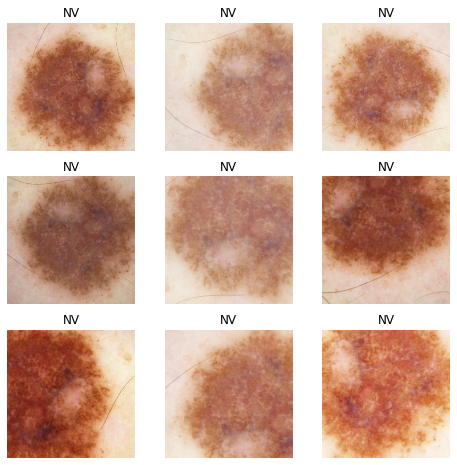

In [18]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [19]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 NV      10334
MEL      3586
BCC      2642
BKL      2092
AK        692
SCC       515
VASC      205
DF        199
dtype: int64 

 valid_count: 
 NV      2541
MEL      936
BCC      681
BKL      532
AK       175
SCC      113
VASC      48
DF        40
dtype: int64
ratios:
NV      0.245887
MEL     0.261015
BCC     0.257759
BKL     0.254302
AK      0.252890
SCC     0.219417
VASC    0.234146
DF      0.201005
dtype: float64 %


In [20]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-6, balanced=True,seed=1):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(seed,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd
                          ,callbacks = [
                            SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
                            CSVLogger(learn=learner,filename=log_name),
                            ]
                         )

## Color correction

In [21]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
  return image.max(dim=1)[0].max(dim=1)[0]
  
def computeGrayWorldOnChannel(image, channel,p):
    I_cx = image[channel].sum()
    img_size = image[channel].shape.numel()
    return ( (I_cx ** p) / img_size )  ** (1/p) 

def shades_of_gray(img, p):
    n_channels, height, width  = img.shape
    iluminant = torch.zeros(3)
    for channel in range(n_channels):
        iluminant[channel] = computeGrayWorldOnChannel(img,channel,p)
    return iluminant

In [22]:
def correct_iluminant(estimated_iluminant):
    gamma = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = gamma * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

In [23]:
def _correct_color_max_rgb(image):
    estimated_iluminant = max_rgb(image);

    c = correct_image(image,estimated_iluminant)
    return c

def _correct_color_shades_of_gray(image):
    estimated_iluminant = shades_of_gray(image,1);

    c = correct_image(image,estimated_iluminant)
    return torch.clamp(c,0,1)

correct_color_max_rgb = TfmPixel(_correct_color_max_rgb)
correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray)

# Training

First let's see the baseline result
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True
* Efficientnet-b0

train_count: 
 NV      10334
MEL      3586
BCC      2642
BKL      2092
AK        692
SCC       515
VASC      205
DF        199
dtype: int64 

 valid_count: 
 NV      2541
MEL      936
BCC      681
BKL      532
AK       175
SCC      113
VASC      48
DF        40
dtype: int64
ratios:
NV      0.245887
MEL     0.261015
BCC     0.257759
BKL     0.254302
AK      0.252890
SCC     0.219417
VASC    0.234146
DF      0.201005
dtype: float64 %

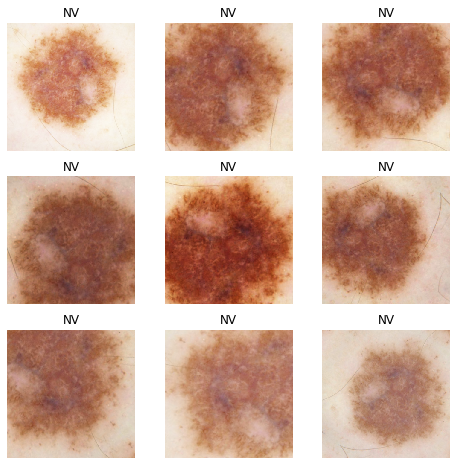

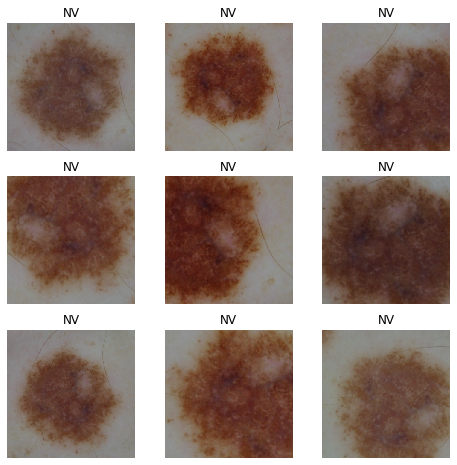

In [34]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());
plot_multi(_plot, 3, 3, figsize=(8,8))

In [35]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.model import MBConvBlock
from efficientnet_pytorch.utils import drop_connect
from torchvision.models.resnet import Bottleneck
import types

random_seed(1,True)

model_name = 'efficientnet-b4'
model_b4_arl = EfficientNet.from_pretrained(model_name)
model_b4_arl._fc = nn.Linear(1792, data.c) # si es b0 poner aca 1280, si es b3 poner 1536



Loaded pretrained weights for efficientnet-b4


In [36]:
alpha_initial_value = 0.001
    
def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs + (inputs 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha) # skip connection
        return x
    
def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, MBConvBlock): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [37]:
apply_leaf(model_b4_arl, change_basic_blocks)

In [38]:
mbconvs = [bn for bn in model_b4_arl.modules() if isinstance(bn,MBConvBlock)]

In [39]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [40]:
learn_b4_arl = Learner(data,model_b4_arl,metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=mbconvs)])
# learn_b0_arl.summary()

In [46]:
learn_b4_arl.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-03
Min loss divided by 10: 9.12E-04


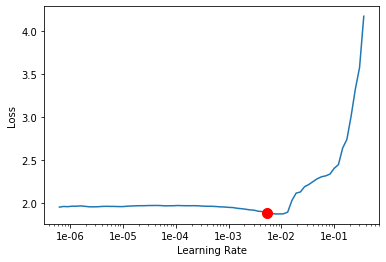

In [48]:
learn_b4_arl.recorder.plot(suggestion=True)

In [41]:
train_learner(learn_b4_arl,'EfficientNet-b0',lr=9.12E-04,epochs=40)

[{'AK': 234.27745664739885}, {'BCC': 61.362604087812265}, {'BKL': 77.49521988527725}, {'DF': 814.6733668341709}, {'MEL': 45.209146681539316}, {'NV': 15.688020127733695}, {'SCC': 314.79611650485435}, {'VASC': 790.829268292683}]
Saving log on:  2019_imgsz_428_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


RuntimeError: number of dims don't match in permute